# Реализация простой нейронной сети

## Нейрон
Нейрон представляет собой следующий математический объект:

$$n = f(\vec w*\vec x + h)$$

Где *n* - результат работы нейрона, $\vec x$ - значения, получаемые
нейроном в качестве параметров, $\vec w$ - корректировочные веса,
придаваемые входным значениям, $h$ - свободный член, а $f(t)$ - функция активации

Задача функции активации состоит в том, чтобы вычисляемые нейронами значения были
ограничены, а также, как правило, в подавлении больших и "усилении" малых значений

In [14]:
# Попробуем реализовать свой собственный нейрон
# В качестве функции активации выберем сигмоиду
from math import exp
import numpy as np

sig = lambda x: (ex := exp(x))/(ex + 1)

class Neuron:
    def __init__(self, inputs: int):
        self.shape = (inputs,)
        # Это веса нашего нейрона и свободный член
        self.weights = np.random.rand(inputs + 1)

    def calculate(self, x: np.array) -> np.array:
        # проверим возможность матричного перемножения
        if x.shape != self.shape:
            raise Exception()
        return sig(np.dot(self.weights, np.append(x, 1)))


x = np.random.rand(5)
n = Neuron(5)
# Вот наш нейрон вычислил некоторое значение
print(n.calculate(x))

0.7129931052444277


## Слой

Классическая нейронная сеть прямого распространения представляет собой набор слоёв, каждый из которых получает
на вход результат вычисления предыдущего слоя

Первый слой получает на вход данные для нейронной сети, а выход последнего слоя - это результат работы всей модели

Слой можно быол бы реализовать, как класс-контейнер для множества
нейронов, но такая никапсуляция излишня, кроме того есть небольшой секрет,
который позволит сделать процесс вычисления всего слоя намного быстрее
благодаря *numpy*:

Слой - одномерный набор нейронов. Значит если мы представим слой, как
матрицу, в строках которой нейроны, а в столбцах - их коэффициенты,
то весь слой легко представить, как векторную функцию:

$$
output = \vec F(\vec o) \\
\vec o =
\begin{pmatrix}
w_{11} & w_{12} & \dots & w_{1p} & b_1\\
\ddots & \ddots & \ddots & \ddots & \ddots \\
w_{n1} & w_{n2} & \dots & w_{np} & b_n
\end{pmatrix}
*
\begin{pmatrix}
x_1 \\
\vdots \\
x_p \\ 
1
\end{pmatrix}
$$

И действительно, легко заметить, что тогда каждый элемент в выхожном векторе есть $f(\vec w*\vec x + b)$

In [10]:
# Для начала реализуем несколько исключений, которые нам понадобятся

class LibraryException(Exception):
    def __init__(self, msg: str, errs: list = None):
        super().__init__(msg)
        self.errs = errs
        if self.errs:
            for e in self.errs:
                print("\t", e)


# Для универсальности слоёв и функций активации, сделаем исключение базового класса.
# Мы делаем его потому, что я люблю type annotations
class DummyClassException(LibraryException):
    def __init__(self, classtype: type):
        super().__init__("The {} class is unusable due to being a base class".format(classtype.__name__))


# Ранее вы заметили, что я проверяю размерности. Данное исключение будем использовать именно для этого
class ShapeMismatchException(LibraryException):
    def __init__(self, classtype: type, function, need: tuple[int], got: tuple[int]):
        super().__init__("{} expected {} shape in function {}, got {}".format(classtype.__name__, need, function.__name__, got))


class InternalShapeException(ShapeMismatchException):
    pass

In [11]:
# Базовый класс, обеспечивающий вариативность выбора функции при создании слоя
class Activation:
    
    # Вычисление значения от СКАЛЯРА
    @staticmethod
    def value(x: float) -> float:
        raise DummyClassException(Activation)

    # Производная в СКАЛЯРНОЙ точке. Она понадобится нам позже.
    @staticmethod
    def derive(x: float) -> float:
        raise DummyClassException(Activation)


class SigmoidActivation(Activation):
    @staticmethod
    def value(x: float) -> float:
        ex = exp(x)
        return ex/(ex+1)

    @staticmethod
    def derive(x: float) -> float:
        val = SigmoidActivation.value(x)
        return val*(1-val)

In [22]:
# Реализуем слой
# Функцию активации для простоты будем применять поэлементно
# Также реализуем функции активации в виде классов так, чтобы можно было использовать любую из них при создании слоя


# Базовый класс для слоя. Он нам тоже понадобится позже
class Layer:
    def __init__(self, input_size: int, output_size: int, activation_type: type[Activation]):
        self.neural_shape = (input_size, output_size)
        self.matrix_shape = (output_size, input_size+1)
        self.inputs_shape = (input_size,)
        self.output_shape = (output_size,)
        self.activation = activation_type
        self.neurons = None

        self.last_inputs = None
        self.last_activated = None
        self.last_unactivated = None

    def calculate(self, inputs: np.array) -> np.array:
        raise DummyClassException(Layer)


# Так называемый входной слой. Он ничего не делает с получаемыми данными, просто отдает то, что взял
# Он нам будет нужен, потому что.
class InputLayer(Layer):
    def __init__(self, input_size: int):
        super().__init__(input_size, input_size, Activation)

    def calculate(self, inputs: np.array) -> np.array:
        self.last_inputs = np.ndarray.copy(inputs)
        self.last_unactivated = np.ndarray.copy(inputs)
        self.last_activated = np.ndarray.copy(inputs)

        return self.last_activated
    

# собственно наш полносвязный слой, который представлен матрицей
class D1FullLayer(Layer):
    def __init__(self, input_size: int, output_size: int, activation_type: type[Activation]):
        super().__init__(input_size, output_size, activation_type)

        # Вот матрица, о которой я говорил ранее
        # output_size - по сути число нейронов
        self.neurons = np.random.rand(output_size, input_size+1)

    def calculate(self, inputs: np.array) -> np.array:
        if self.inputs_shape != inputs.shape:
            raise ShapeMismatchException(D1FullLayer, self.calculate, self.inputs_shape, inputs.shape)

        self.last_inputs = np.append(inputs, 1)
        output = np.dot(self.neurons, self.last_inputs)
        if self.output_shape != output.shape:
            raise InternalShapeException(D1FullLayer, self.calculate, self.output_shape, output.shape)

        self.last_activated = np.array([self.activation.value(x) for x in output])
        self.last_unactivated = output

        return self.last_activated

In [26]:
# Проверим, как будет работать наш слой

lyr = D1FullLayer(5, 2, SigmoidActivation)
print(lyr.calculate(x))
print()
lyr = D1FullLayer(5, 10, SigmoidActivation)
print(lyr.calculate(x))

print()
# Ну и входной слой для чистоты эксперимента
lyr = InputLayer(5)
print(lyr.calculate(x))
print(lyr.calculate(x) == x)

[0.65433401 0.67623598]

[0.7750444  0.80447129 0.62826357 0.58115458 0.79493565 0.59372882
 0.67987501 0.60867778 0.68213496 0.61264069]

[0.05626878 0.12284134 0.03620381 0.48363657 0.0138788 ]
[ True  True  True  True  True]


# Нейронная сеть

Наша сеть, с точки зрения математики, - это просто большая векторная функция. С практической точки зрения это список слоёв, через который прогоняется входной вектор.

Реализуем его:

In [32]:
class SimpleNetwork:
    def __init__(self, input_size: int):
        self.inputs_shape = (input_size,)
        self.output_shape = (None,)
        # так называемый входной слой добавляем автоматически
        self.layers: list[Layer] = [InputLayer(self.inputs_shape[0])]

    def add(self, layer_type: type[Layer], output_size: int, activation_type: type[Activation]):
        input_size = self.layers[-1].output_shape[0]

        self.layers.append(layer_type(input_size=input_size, output_size=output_size, activation_type=activation_type))
        self.output_shape = self.layers[-1].output_shape

    # Сразу реализуем метод для вычисления множества значений для множества входных векторов
    def predict_many(self, x: np.array) -> np.array:
        result = []
        for example_num, example in enumerate(x):
            result.append(self.predict(example))

        return np.array(result)

    def predict(self, x: np.array) -> np.array:
        output = np.ndarray.copy(x)
        for layer in self.layers:
            output = layer.calculate(output)

        return output

In [33]:
# Посмотрим, что вычислит наша нейронная сеть:

net = SimpleNetwork(5)
net.add(D1FullLayer, 5, SigmoidActivation)
net.add(D1FullLayer, 10, SigmoidActivation)
net.predict(x)

array([0.91188291, 0.89595165, 0.92336765, 0.9237787 , 0.93491812,
       0.87954396, 0.87940511, 0.78510731, 0.85089038, 0.92262813])

# Обучение сети

Наша сеть теперь умеет вычислять векторы, получая на вход векторы. Но надо научить ее вычислять векторы, похожие на векторы из обучающих примеров.

Как уже упоминалось ранее, по сути нейронаая сеть - это векторная функция $\vec o(\vec x)$

Для того, чтобы результат работы сети стал похож на то, что мы ей даём, нужно определить меру похожести. Я буду использовать среднюю квадратичную ошибку *MSE*:
$$
MSE(x) = \frac{1}{n} \sum^{n}(real - predicted)^2
$$

Она-то и покажет нам, насколько мы "хорошо" обучили нашу сеть.

## Градиентный спуск
Теперь становится ясно, что обучение сети - по сути есть изменение ее параметров таким образом, чтобы значение функции ошибки было минимально.

На одних и тех же данных наша функция ошибки (назовем ее *L*), очевидно, зависит от параметров нейронной сети, так как зависит (при одних и тех же данных) именно от того, что сеть выдаёт в качестве ответа.

Таким образом, имея функцию $L(p_1, \dots, p_n)$, где $p_k = [[w_11,\dots,b_1],\dots,[w_i1,\dots,b_i]]$ - параметры слоя, мы можем попытаться так подстроить параметры функции *L*, чтобы она становилась меньше и меньше

Для этого нам всего лишь надо вычислить градиент этой функции и сместить вектор параметров на антиградиент.

Данная функция - сложная, и имеет следующий вид:
$$
L(\dots) = MSE(real - \vec o(\vec x))
$$
её частные производные по параметрам равны
$$
\frac{\delta L}{\delta w} = \frac{\delta L}{\delta \vec o}*\frac{\delta \vec o}{\delta w}
$$

Теперь посчитаем производную функции $\vec o(\vec x)$: вспомним, что каждый нейрон - вложенная функция внутри $\vec o(\vec x)$, которая как раз и зависит от параметров *w*. Стало быть производная имеет вид

$$
\frac{\delta \vec o}{\delta w} = \frac{\delta \vec o}{\delta n} * \frac{\delta \vec n}{\delta w}
$$

Таким образом
$$
\frac{\delta L}{\delta w} = \frac{\delta L}{\delta \vec o}*\frac{\delta \vec o}{\delta n} * \frac{\delta \vec n}{\delta w}
$$

Здесь $\frac{\delta L}{\delta \vec o}$ - всего лишь производная функции ошибки, $\frac{\delta \vec n}{\delta w}$ - производная функции активации, а вот $\frac{\delta \vec o}{\delta n}$ - зависит не только от выхода сети, но и от того, сколько слоёв следует после текущего.

По сути $\frac{\delta \vec o}{\delta n}$ - тоже сложная функция с разной глубиной для разных слоев, так что ее вычисление будет реализовываться на уровне сети

In [34]:
# Итак, реализуем недостающие компоненты:
class Loss:
    @staticmethod
    def value(real: np.array, predicted: np.array) -> float:
        raise DummyClassException(Loss)

    @staticmethod
    def derive(real: np.array, predicted: np.array) -> float:
        raise DummyClassException(Loss)


class MeanSquaredError(Loss):
    @staticmethod
    def value(real: np.array, predicted: np.array) -> float:
        errors = np.array([((real[i] - predicted[i])**2).sum() for i, _ in enumerate(real)])
        return errors.mean()

    @staticmethod
    def derive(real: np.array, predicted: np.array) -> float:
        errors = np.array([(-2*(real[i] - predicted[i])).sum() for i, _ in enumerate(real)])
        return errors.mean()

In [35]:
# Добавим в класс сети метод для обучения, который просто вычисляет частные производные по всем параметрам сети
# А потом поправляет эти параметры на получившийся антиградиент


class Network(SimpleNetwork):
    def fit(self, x: np.array, y: np.array, loss_type: type[Loss], lr: float = 0.1):
        predicted = self.predict_many(x)
        loss = loss_type.value(x, predicted)
        dL_dPred = loss_type.derive(y, predicted)

        for layer_num, _ in reversed(tuple(enumerate(self.layers))[1:-1]):
            next_l = self.layers[layer_num+1]
            layer = self.layers[layer_num]

            for neuron_num, neuron in enumerate(layer.neurons):
                dPred_dH = (next_l.neurons[:, neuron_num]*[next_l.activation.derive(x) for x in next_l.last_unactivated]).mean()

                for w_num, _ in enumerate(neuron):
                    p1 = layer.last_inputs[w_num]
                    p2 = layer.activation.derive(layer.last_unactivated[neuron_num])
                    dH1_dW = p1*p2
                    layer.neurons[neuron_num][w_num] -= dL_dPred*dPred_dH*dH1_dW*lr

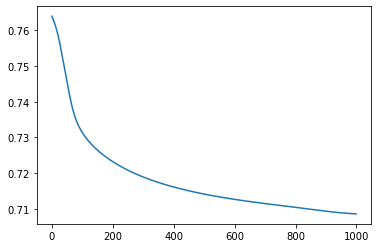

In [41]:
#И проверим, как учится наша сеть, посмотрев, как меняется значение ошибки:
import matplotlib.pyplot as plt

x = np.array([
    [1,2,3],
    [2,3,1],
    [-1,-2,-3],
    [-3,-3,-3],
    [1,2,3],
    [2,3,1],
    [-1,-2,-3],
    [-3,-3,-3],
    [1,2,3],
    [2,3,1],
    [-1,-2,-3],
    [-1,-3,-3]
])
y = np.array([
    [1],
    [1],
    [2],
    [2],
    [1],
    [1],
    [2],
    [2],
    [1],
    [1],
    [2],
    [2]
])

net = Network(3)
net.add(D1FullLayer, output_size=3, activation_type=SigmoidActivation)
net.add(D1FullLayer, output_size=2, activation_type=SigmoidActivation)
net.add(D1FullLayer, output_size=1, activation_type=SigmoidActivation)

mse_history = []

oldmse = MeanSquaredError.value(y, pred := net.predict_many(x))
newmse = oldmse - 1


count = 0
while count < 1000 and (oldmse-newmse) > 0.000001:
    count += 1
    oldmse = MeanSquaredError.value(y, pred)
    net.fit(x, y, MeanSquaredError, lr=0.1)
    newmse = MeanSquaredError.value(y, pred := net.predict_many(x))
    mse_history.append(newmse)

#%%

plt.plot(mse_history)

# В результате

Мы видим, что функция ошибки уменьшается.

Наша сеть обучается, и мы прекрасны